Titanic Survivor Analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # library used for data visualization
import matplotlib.pyplot as plt # library used for data visualization
import re # library to work with Regular Expressions
from sklearn.preprocessing import LabelEncoder # used to encode categorical features to numerical ones

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Suppress warnings
import warnings  
warnings.filterwarnings('ignore')

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
# Read train and test data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Print shape of train and test data
print("Train shape:{}".format(train.shape))
print("Test shape:{}".format(test.shape))

Train shape:(891, 12)
Test shape:(418, 11)


In [3]:
# Show first rows from train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Feature description:
* PassengerId: ID of a passenger
* Survived: if passenger survived sinking of the Titanic (1 - survived, 0 - didn't survived)
* Pclass: passenger class (1, 2 or 3)
* Name: full name of the passenger
* Sex: passenger sex  (male or feamale)
* Age: passenger age in years
* SibSp: number of siblings or spouses aboard the Titanic
* Parch: number of parents or children aboard the Titanic
* Ticket: ticket number
* Fare: passenger fare
* Cabin: passenger cabin number
* Embarked: port of embarkation (S = Southampton, C = Cherbourg, Q = Queenstown)

In [4]:
# Describe train numeric features
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Check which data is missing in train dataset
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Only three features with missing data: Age, Cabin and Embarked.

In [6]:
# Check which data is missing in test dataset
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

0    549
1    342
Name: Survived, dtype: int64

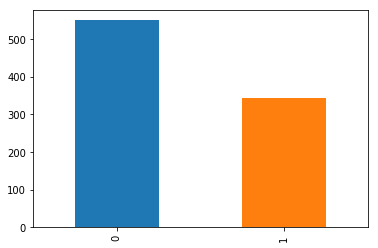

In [7]:
# How many passengers survived?
train['Survived'].value_counts().plot(kind='bar')
train['Survived'].value_counts()

# Only around 30% of passengers survived

1    216
2    184
3    491
Name: Pclass, dtype: int64

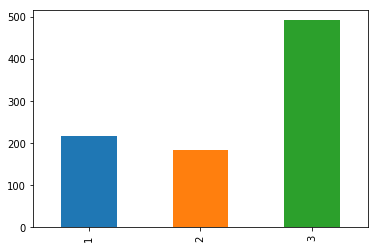

In [8]:
# How many passengers were in each calss?
train['Pclass'].value_counts().sort_index().plot(kind='bar')
train['Pclass'].value_counts().sort_index()

# As we can see most passengers traveled in 3rd class (low socioeconomic status)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


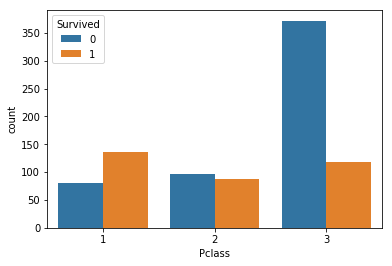

In [9]:
# How many people survived in each class?
sns.countplot(x='Pclass', hue='Survived', data=train)
pd.crosstab(train['Pclass'], train['Survived'])

# In 2nd class more passengers survived than died (slightly, but still).

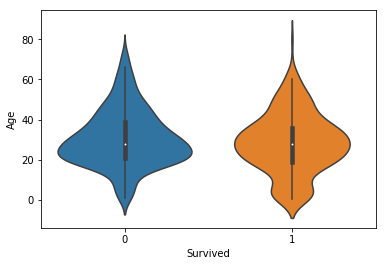

In [10]:
# How age was importat to survival?
sns.violinplot(x='Survived', y='Age', data=train)

# As we can see the age was important only in case of children in favour of their survival.

In [11]:
# What is mean, median age based on the passenger class?
train.groupby(['Pclass','Sex'])['Age'].aggregate(['mean','median','max','min'])

mean  median   max   min
Pclass Sex                                  
1      female  34.611765    35.0  63.0  2.00
       male    41.281386    40.0  80.0  0.92
2      female  28.722973    28.0  57.0  2.00
       male    30.740707    30.0  70.0  0.67
3      female  21.750000    21.5  63.0  0.75
       male    26.507589    25.0  74.0  0.42

In [12]:
# Lets fill in missing values for age with median age based on passenger class and their sex.
train.loc[train['Age'].isnull(), 'Age'] = train.groupby(['Pclass','Sex'])['Age'].transform('median')
test.loc[test['Age'].isnull(), 'Age'] = test.groupby(['Pclass','Sex'])['Age'].transform('median')

In [13]:
# Bin age
age_bins = [0,9,19,29,39,49,59,69,80]
age_bins_labels = ['0s','10s','20s','30s','40s','50s','60s','70s']
train['AgeBin'] = pd.cut(train['Age'], age_bins, labels=age_bins_labels)
test['AgeBin'] = pd.cut(test['Age'], age_bins, labels=age_bins_labels)

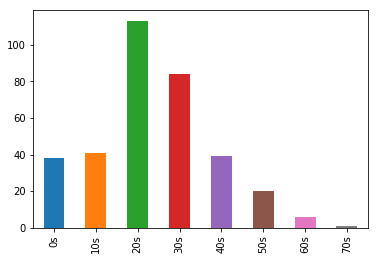

In [14]:
# Display age bins of survived passengers (closer look which can be already observed in violin plot)
train[train['Survived'] == 1]['AgeBin'].value_counts().sort_index().plot(kind='bar')

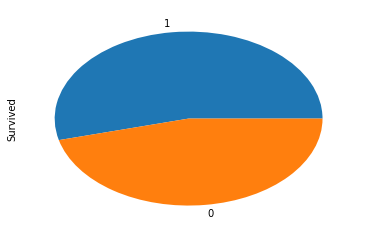

In [15]:
# So, how may passengers survived in case of passenger below age of 20?
train[train['Age'] < 18]['Survived'].value_counts().apply(
    lambda x: x/len(train[train['Age'] < 18])).plot(kind='pie')

# As we can see slighty more then half of the children (age < 18) survived. 

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

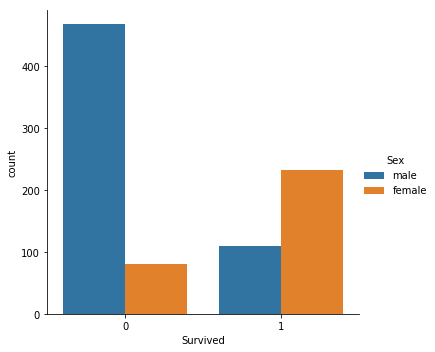

In [16]:
# How sex was important for survival?
sns.catplot(hue='Sex',x='Survived',data=train, kind='count')
train.groupby('Sex')['Survived'].value_counts()

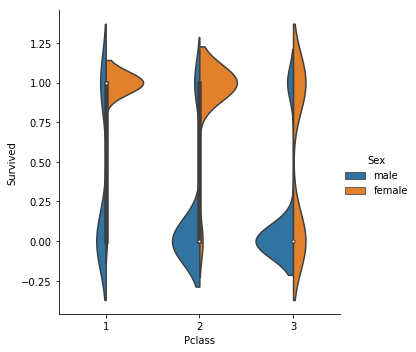

In [17]:
# How sex based on passenger class was important for survival?
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='violin', split='ture')

In [18]:
# Before plotting data based on feature Embarked, we need to fill in missing values.
print(train['Embarked'].value_counts())

# We will fill in missing values with the most common one. In this case is 'S'.
train.loc[train['Embarked'].isnull(), 'Embarked'] = 'S'

S    644
C    168
Q     77
Name: Embarked, dtype: int64


Embarked  Survived
C         1            93
          0            75
Q         0            47
          1            30
S         0           427
          1           219
Name: Survived, dtype: int64

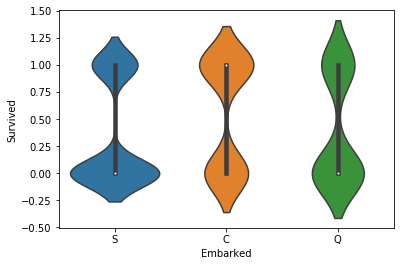

In [19]:
# Is port where passenger embark on Titanic important for survival?
sns.violinplot(x='Embarked', y='Survived', data=train)
train.groupby('Embarked')['Survived'].value_counts()

# It does not matter in which port the passenger boarded the Titanic.
# His chances of survival among the other people from this port were around 50%.
# Conclusion: port is probably not important. 
# People who boarded the Titanic in C were more likely to survive among the other people from the same port.

Parch  Survived
0      0           445
       1           233
1      1            65
       0            53
2      0            40
       1            40
3      1             3
       0             2
4      0             4
5      0             4
       1             1
6      0             1
Name: Survived, dtype: int64

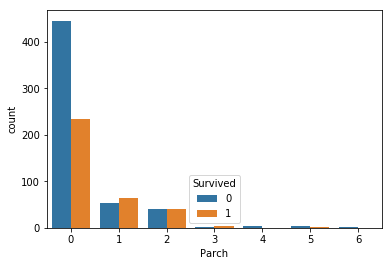

In [20]:
# Having a parent or children aboard was important for survival?
sns.countplot(x='Parch', hue='Survived', data=train)
train.groupby('Parch')['Survived'].value_counts()

# Having more children or parents aboard slightly decreases chances of survival.

SibSp  Survived
0      0           398
       1           210
1      1           112
       0            97
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
Name: Survived, dtype: int64

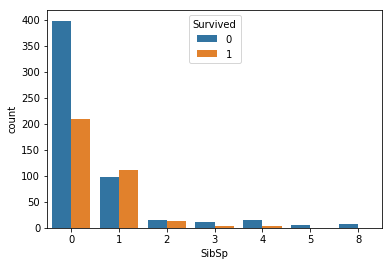

In [21]:
# Having siblings or spouse aboard was important for survival?
sns.countplot(x='SibSp', hue='Survived', data=train)
train.groupby('SibSp')['Survived'].value_counts()

# Having more than 2 SibSp decrease chances of survival.

In [22]:
# Create new feature FamilySize = SibSp + Parch
train['FamilySize'] = train['SibSp'] + train['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']

Survived,0,1
FamilySize,,
0,374,163
1,72,89
2,43,59
3,8,21
4,12,3
5,19,3
6,8,4
7,6,0
10,7,0


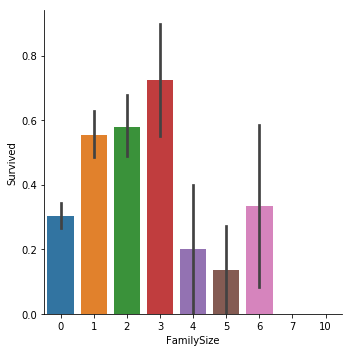

In [23]:
# How family size was important for survival
sns.factorplot(x='FamilySize', y='Survived', data=train, kind='bar')
pd.crosstab(train['FamilySize'], train['Survived'])

# Passengers that had 1-3 family members had better chance for survival. 
# Specialy in case of famly size 3. Big families weren't so luckly.

In [24]:
# How much of cabin data is missing?
print("Missed data in Cabin = {:.2}%".format(train['Cabin'].isnull().sum()/len(train['Cabin'])))

# Although there is a lot of missing values (so lot that this feature should be excluded 
# before training the model) lets try to get some insights from the data there is avaiable.

Missed data in Cabin = 0.77%


In [25]:
# Create new feature (deck) based on first letter from cabin.
# Missing values will be assigned to deck 'n'.
train['Deck'] = train['Cabin'].astype(str).apply(lambda x: x[0])
test['Deck'] = test['Cabin'].astype(str).apply(lambda x: x[0])

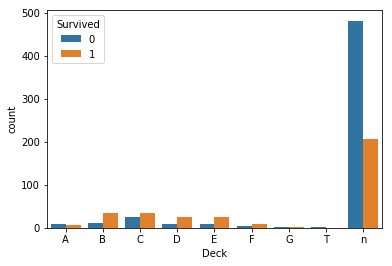

In [26]:
# How many passengers survived based on deck where their cabin was located?
sns.countplot(x='Deck', hue='Survived', data=train, order=np.sort(train['Deck'].unique()))

# In decks B,C,D,E,F there are more passengers that survived than died.

,min,max,mean,median,count
Deck,,,,,
A,0.0000,81.8583,39.623887,35.50000,15
B,0.0000,512.3292,113.505764,80.00000,47
C,26.5500,263.0000,100.151341,83.47500,59
D,12.8750,113.2750,57.244576,53.10000,33
E,8.0500,134.5000,46.026694,45.18125,32
F,7.6500,39.0000,18.696792,13.00000,13
G,10.4625,16.7000,13.581250,13.58125,4
T,35.5000,35.5000,35.500000,35.50000,1
n,0.0000,512.3292,19.157325,10.50000,687


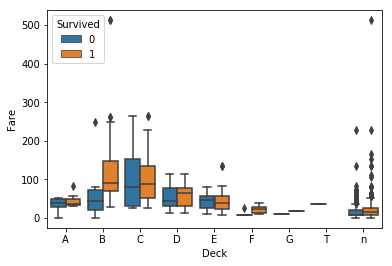

In [27]:
# How deck is connected with fare and survival rate?
sns.boxplot(x='Deck', y='Fare', hue='Survived', data=train, order=np.sort(train['Deck'].unique()))
train.groupby('Deck')['Fare'].aggregate(['min','max','mean','median','count'])

# Deck that are more expensive had higher rate of survival.

,min,max,mean,median,count
Pclass,,,,,
1,0.0,512.3292,84.154687,60.2875,216
2,0.0,73.5000,20.662183,14.2500,184
3,0.0,69.5500,13.675550,8.0500,491


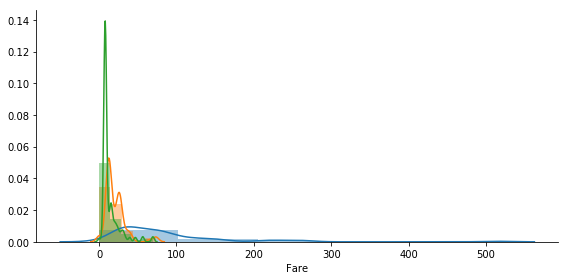

In [28]:
# Is passengers class based on fare?
g = sns.FacetGrid(train, hue="Pclass", height=4, aspect=2)
g = g.map(sns.distplot, "Fare", bins=5)

train.groupby('Pclass')['Fare'].aggregate(['min','max','mean','median','count'])

# As we can see higher class mean higher fare (blue=1st, orange=2nd, green=3rd).
# We could try to guess passenger deck based on fare and class:
# 3rd -> G,F,T
# 2nd -> A,E,D
# 1st -> C,B
# But we will not do it, because there is too much data missing
# and we could fit model on wrong features.

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Sir           1
Ms            1
Lady          1
Mme           1
Countess      1
Capt          1
Don           1
Name: Title, dtype: int64

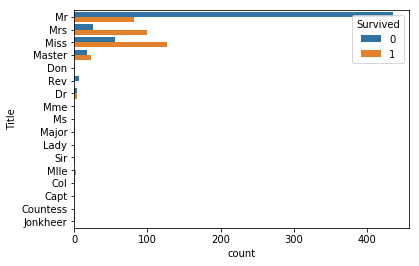

In [29]:
# Lets try to get some insights from Name
# Get title from passenger name
train['Title'] = train['Name'].apply(lambda x: re.search(' ([A-z]+)\.', x).group(1))
test['Title'] = test['Name'].apply(lambda x: re.search(' ([A-z]+)\.', x). group(1))

# Get count of all titles
sns.countplot(y='Title', hue='Survived', data=train,)
train['Title'].value_counts()

In [30]:
# There is a lot of titles with a small count. Lets group them in some way.
title_dict = {
    'Mr': 'Mr', # adult man (regardless of marital status)
    'Mrs': 'Mrs', # adult woman (married women, widows, and divorcées)
    'Mme': 'Mrs', # french title equivalent to english Ms
    'Ms': 'Mrs', # adult woman (regardless of marital status)
    'Miss': 'Miss', # female children and unmarried women
    'Mlle': 'Miss', # french title given to an unmarried woman (equivalent to english Miss)
    'Master':  'Master', # male children (young boys)
    'Major': 'Officer', # military rank
    'Col': 'Officer', # military rank
    'Capt': 'Officer', # military rank
    'Lady': 'Royalty',
    'Sir': 'Royalty',
    'Don': 'Royalty',
    'Dona': 'Royalty',
    'Countess': 'Royalty', 
    'Jonkheer': 'Royalty', # lowest rank within the nobility
    'Rev': 'Rev', # the Reverend
    'Dr': 'Dr' # academic title
}

train['Title'] = train['Title'].map(title_dict)
test['Title'] = test['Title'].map(title_dict)

Survived,0,1
Title,,
Dr,4,3
Master,17,23
Miss,55,129
Mr,436,81
Mrs,26,101
Officer,3,2
Rev,6,0
Royalty,2,3


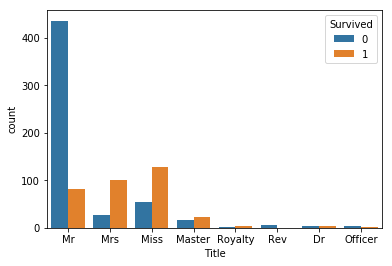

In [31]:
# How title (grouped) was important in survival?
sns.countplot(x='Title', hue='Survived', data=train)
pd.crosstab(train['Title'], train['Survived'])

# So we can see what we already know, first they saved women and children.
# One important thing that we can see, is that young boys were taken after womens (adults and children).
# This is what we can suspect from plot below.

min        0.42000
max       25.00000
mean       6.61675
median     4.00000
Name: Age, dtype: float64


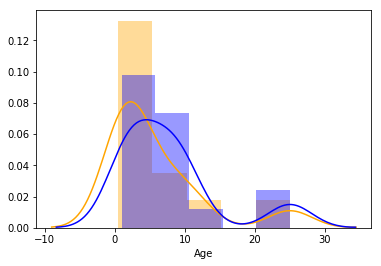

In [32]:
# Since the young boys were not so eagerly saved, it's worth taking a closer look at them.
print(train[train['Title'] == 'Master']['Age'].aggregate(['min','max','mean','median']))

survived_boys = train[(train['Title'] == 'Master') &
                    (train['Survived'] == 1)]
dead_boys = train[(train['Title'] == 'Master') &
                    (train['Survived'] == 0)]

sns.distplot(survived_boys['Age'], bins=5, color='orange')
sns.distplot(dead_boys['Age'], bins=5, color='blue')

# There is no patter so we could predict which boys survived and which don't.

Survived,0,1
Pclass,,
1,0,3
2,0,9
3,17,11


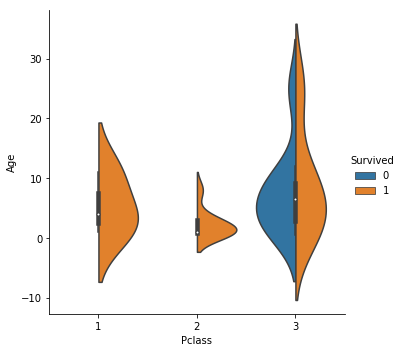

In [33]:
# How class and age of boys were connected with their survival?
sns.catplot(x='Pclass', y='Age', hue='Survived', data=train[train['Title'] == 'Master'], 
            kind='violin', split='ture')
pd.crosstab(train[train['Title'] == 'Master']['Pclass'],train[train['Title'] == 'Master']['Survived'])

# Young boys were saved in first place only if
# they traveled in 1st or 2nd class (every one of them survived).

In [34]:
# Before training model, it is better to chnage Fare from numerical values to some categories.
# Lets asume below categories:
# (79+]     = very_high
# (44-79]   = high
# (19-44]   = above_average
# (9-19]    = normal
# (-1-9]    = cheap
# NaN       = unknown

# Create bins and corresponding categories
fare_bins = [-20, -1, 9, 19, 44, 79, 700]
fare_bins_cat = ['unknown','cheap','normal','above_average','high','very_high']

# Fill in missing values with value -10
train['Fare'] = train['Fare'].fillna(-10)
test['Fare'] = test['Fare'].fillna(-10)

# Create new feature FareBin
train['FareBin'] = pd.cut(train['Fare'], fare_bins, labels=fare_bins_cat)
test['FareBin'] = pd.cut(test['Fare'], fare_bins, labels=fare_bins_cat)

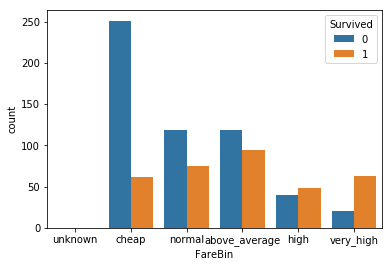

In [35]:
# Is fare range connected with survival?
sns.countplot('FareBin', hue='Survived', data=train)

# What we already known: higher price, higher survival rate

In [36]:
# Get Ticket prefix
#train['TicketPrefix'] = train['Ticket'].apply(lambda x: re.search('([A-z]+.*)( )', x).group(1)
#                                              .replace('.','').replace(' ','') 
#                                              if re.search('[A-z]+.* ', x) != None 
#                                              else 'NUMBER')

Feature preparation

In [37]:
# We need to save passengerId from test set, because it will be needed in creating the output file.
passengerId = test['PassengerId']

# Firstly lets remove all unnecessary features
features_to_remove = ['PassengerId','Ticket','Cabin','Name']
train.drop(features_to_remove, axis=1, inplace=True)
test.drop(features_to_remove, axis=1, inplace=True)

In [38]:
# Secondly we need to convert categorical features (objects) to numerical ones before fitting the model
# There are two possibilities to achive this, use pandas get_dummies or use LabelEncoder.
def encode_feature(train, test, features):
    data_combined = pd.concat([train[features], test[features]])
    for feature in features:
        label_encoder = LabelEncoder().fit(data_combined[feature])
        train[feature] = label_encoder.transform(train[feature])
        test[feature] = label_encoder.transform(test[feature])
    return train, test

#train, test = encode_feature(train, test, ['Sex','Embarked','AgeBin','Deck','Title','FareBin'])

# One-hot-encoding of categorical features
train = pd.get_dummies(train, columns=['Sex','Embarked','AgeBin','Deck','Title','FareBin'],
                       drop_first=True)
test = pd.get_dummies(test, columns=['Sex','Embarked','AgeBin','Deck','Title','FareBin'],
                      drop_first=True)

# Ensure that train and test have the same number of columns. 
# If columns is missing add it and fill in with 0.
train,test = train.align(test, join='outer', axis=1, fill_value=0)
del test['Survived']

In [39]:
# Lets check our data after encoding features
train.head()

,Age,AgeBin_10s,AgeBin_20s,AgeBin_30s,AgeBin_40s,AgeBin_50s,AgeBin_60s,AgeBin_70s,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_n,Embarked_Q,Embarked_S,FamilySize,Fare,FareBin_above_average,FareBin_cheap,FareBin_high,FareBin_normal,FareBin_very_high,Parch,Pclass,Sex_male,SibSp,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Rev,Title_Royalty
0,22.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,7.2500,0,1,0,0,0,0,3,1,1,0,0,0,1,0,0,0,0
1,38.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,71.2833,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0
2,26.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,7.9250,0,1,0,0,0,0,3,0,0,1,0,1,0,0,0,0,0
3,35.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,53.1000,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0
4,35.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,8.0500,0,1,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0


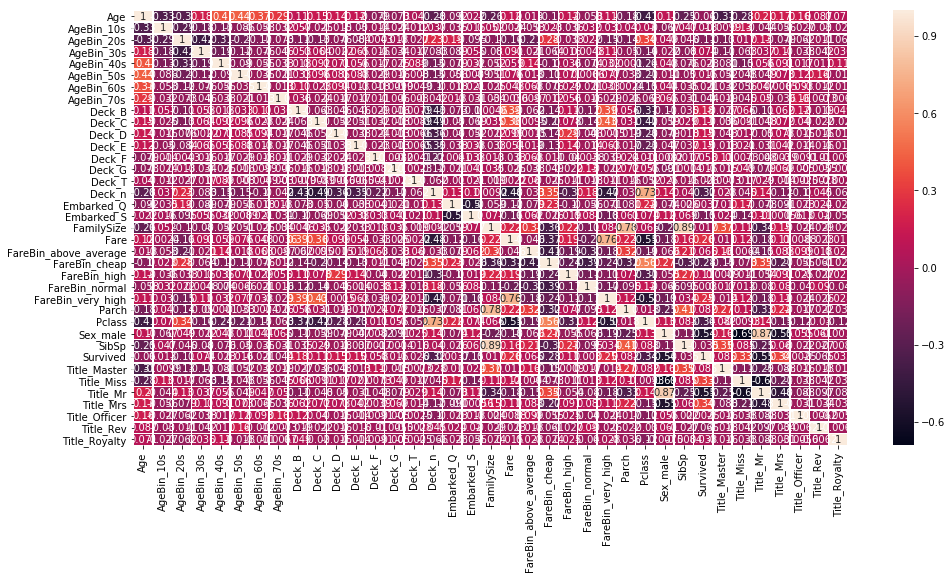

In [40]:
# Plot correlation of data
plt.figure(figsize=(16,8))
sns.heatmap(train.corr(), linewidth=.5, annot=True)

Model

In [41]:
# Model imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [42]:
# Get training features (X) and output label (y)
X = train.drop(['Survived'], axis=1)
y = train['Survived']

# Split X data to train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Simple function that evaluate model
def score(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [43]:
rfc = RandomForestClassifier(random_state=7)
score(rfc, X, y)

Accuracy: 0.80 (+/- 0.01)


In [44]:
lr = LogisticRegression(random_state=7)
score(lr, X, y)

Accuracy: 0.81 (+/- 0.03)


In [45]:
xgb = XGBClassifier(random_state=7)
score(xgb, X, y)

Accuracy: 0.83 (+/- 0.03)


Submition

In [46]:
# We will submit predictions from XGBoostClassifier
# Fit model with all data
xgb.fit(X,y)
# Make predictions for test data
predictions = xgb.predict(test)

# Create submission file
submission = pd.DataFrame({
        'PassengerId': passengerId,
        'Survived': predictions
    })
submission.to_csv('submission.csv', index=False)

NOTES:
* AgeSentinel - missing age data with strange value (for example -100), so model will know that this data should be treated differently.
* Select parameters for the models to boost accuracy.
* Change order of categorial features before passing them to LabelEncoder (order is important!)

References:
* [titanic-eda-keras-nn-pipelines](https://www.kaggle.com/kabure/titanic-eda-keras-nn-pipelines)
* [a-comprehensive-ml-workflow-with-python](https://www.kaggle.com/mjbahmani/a-comprehensive-ml-workflow-with-python)